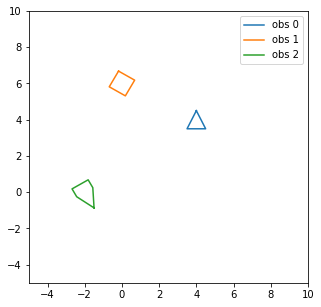

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
class Box2D:
    def __init__(self, x, y, yaw, corner_points=None, v=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.corner_points = corner_points
        self.v = v

corner_points3 = [[0.5, -0.5, -0.5, 0.5],
                 [0.0, 0.5, -0.5, 0.0]]    
corner_points4 = [[0.5, -0.5, -0.5, 0.5, 0.5],
                 [0.5, 0.5, -0.5, -0.5, 0.5]]        
corner_points5 = [[1.0, 0.0, -0.5, -0.5, 0.0, 1.0],
                 [0.0, 0.5, 0.5, -0.5, -0.5, 0.0]]           
obs0 = Box2D(4.0, 4.0, math.pi/2.0, corner_points=corner_points3)
obs1 = Box2D(0.0, 6.0, math.pi/3.0, corner_points=corner_points4)
obs2 = Box2D(-2.0, 0.0, -math.pi/3.0, corner_points=corner_points5)
obs_buf = [obs0, obs1, obs2]
def local2global(x0, y0, yaw0, corner_points):
    R = np.array([[math.cos(yaw0), -math.sin(yaw0)],
                  [math.sin(yaw0), math.cos(yaw0)]])
    corner_arr = np.array(corner_points)
    return np.dot(R, corner_arr)+np.array([[x0],[y0]])
for i, obs in enumerate(obs_buf):
    gcp = local2global(obs.x, obs.y, obs.yaw, obs.corner_points)
    plt.plot(gcp[0], gcp[1], label="obs "+str(i))
    plt.axis([-5, 10, -5, 10])
plt.legend(loc="upper right")

plt.show()

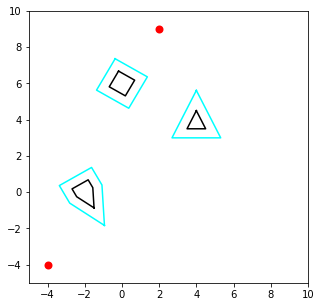

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np

def inflation_obs(obs, r):
    A = []
    inflat_cps = []
    gcp = local2global(obs.x, obs.y, obs.yaw, obs.corner_points)
    for i in range(len(gcp[0])-1):
        v1 = [gcp[0, i], gcp[1, i]]
        v2 = [gcp[0, i+1], gcp[1, i+1]]
        a = v2[0]-v1[0]
        b = v1[1]-v2[1]
        c = v1[1]*a+v1[0]*b
        inflat_c = -r*math.sqrt(a*a+b*b)+c
        A.append([a, b, inflat_c])
    pre_ind = -1
    for i in range(len(A)):
        a1, b1, c1 = A[pre_ind][1], A[pre_ind][0], A[pre_ind][2]
        a2, b2, c2 = A[i][1], A[i][0], A[i][2]
        x = (b2*c1-b1*c2)/(a1*b2-a2*b1)
        y = (a1*c2-a2*c1)/(a1*b2-a2*b1)  
        inflat_cps.append([x, y])
        pre_ind = i
    inflat_cps.append(inflat_cps[0])    
    return A, inflat_cps


plt.figure(figsize=(5, 5))

inflat_cps_buf = []
A_buf = []
for obs in obs_buf:
    gcp = local2global(obs.x, obs.y, obs.yaw, obs.corner_points)
    plt.plot(gcp[0], gcp[1], 'k')
    A, inflat_cps = inflation_obs(obs, 0.5)
    inflat_cps_buf.append(inflat_cps)
    A_buf.append(A)
    plt.plot(np.array(inflat_cps)[:,0],np.array(inflat_cps)[:,1], 'cyan')
plt.scatter(-4.0, -4.0, color='red', linewidth=2)
plt.scatter(2.0, 9.0, color='red', linewidth=2)       
plt.axis([-5, 10, -5, 10])
plt.show()   

Bx1_arr = []
By1_arr = []
Bx2_arr = []
By2_arr = []
for i in range(len(inflat_cps_buf)):
    inflat_cps = inflat_cps_buf[i]
    for j in range(len(inflat_cps)-1):
        Bx1_arr.append(inflat_cps[j][0])
        By1_arr.append(inflat_cps[j][1])
        Bx2_arr.append(inflat_cps[j+1][0])
        By2_arr.append(inflat_cps[j+1][1])
Bx1_arr = np.array(Bx1_arr)
By1_arr = np.array(By1_arr)
Bx2_arr = np.array(Bx2_arr)
By2_arr = np.array(By2_arr)

In [3]:
# time cost is 0.05774664878845215
def line_segment_cross_judge(Ax1, Ay1, Ax2, Ay2, Bx1, By1, Bx2, By2):
    if ((max(Ax1,Ax2)<=min(Bx1,Bx2) or min(Ax1,Ax2)>=max(Bx1,Bx2)) or
        (max(Ay1,Ay2)<=min(By1,By2) or min(Ay1,Ay2)>=max(By1,By2))):
        return False
    if (((Bx1-Ax1)*(Ay2-Ay1)-(By1-Ay1)*(Ax2-Ax1))*((Bx2-Ax1)*(Ay2-Ay1)-(By2-Ay1)*(Ax2-Ax1))<0 and
        ((Ax1-Bx1)*(By2-By1)-(Ay1-By1)*(Bx2-Bx1))*((Ax2-Bx1)*(By2-By1)-(Ay2-By1)*(Bx2-Bx1))<0):
        return True
    return False

def point_in_obs_judge(p, A):
    A_mat = np.array(A)
    x = np.array([p[1], p[0], -1]).T
    M = np.dot(A_mat, x)
    if np.min(M) > 0:
        return True
    return False


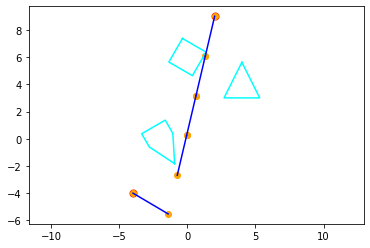

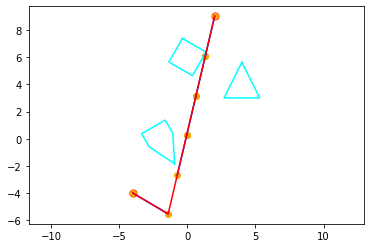

In [36]:
import copy
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
plt.figure(2)

for inflat_cps in inflat_cps_buf:
    plt.plot(np.array(inflat_cps)[:,0],np.array(inflat_cps)[:,1], 'cyan')
plt.scatter(-4.0, -4.0, color='red', linewidth=2)
plt.scatter(2.0, 9.0, color='red', linewidth=2)       
plt.axis([-8, 10, -8, 10])
plt.axis('equal')

class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        
class AreaBounds:
    def __init__(self, area):
        self.xmin = float(area[0])
        self.xmax = float(area[1])
        self.ymin = float(area[2])
        self.ymax = float(area[3])

class RRT(object):
    def __init__(self, start, goal, obs_buf, play_area, 
                 expand_dis=3.0, 
                 goal_sample_rate=5, 
                 max_iter=500):
        self.start = Node(start[0], start[1])
        self.end = Node(goal[0], goal[1])
        self.play_area = AreaBounds(play_area)
        self.expand_dis = expand_dis
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        
        
    def planning(self):
        self.node_list_s = [self.start]
        self.node_list_g = [self.end]
        for i in range(self.max_iter): 
            is_over = False
            path = []
            if (len(self.node_list_s) < len(self.node_list_g)):                
                is_over, path = self.extend_g_tree()
            else: 
                is_over, path = self.extend_s_tree()
            if is_over:
                return path
        return []
            
    def extend_s_tree(self):
        rnd_node = self.get_random_node("start")
        nearest_ind = self.get_nearest_node_index(rnd_node, self.node_list_s)
        nearest_node = self.node_list_s[nearest_ind]

        new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

        if self.check_collision(nearest_node, new_node):
            self.node_list_s.append(new_node)
            plt.plot([nearest_node.x, new_node.x], [nearest_node.y, new_node.y], 'b')
            plt.scatter([nearest_node.x, new_node.x], [nearest_node.y, new_node.y], color='orange')
            if is_ipython:
                display.clear_output(wait=True)
                display.display(plt.gcf())
                
            nearest_ind_sg = self.get_nearest_node_index(new_node, self.node_list_g)
            nearest_node_sg = self.node_list_g[nearest_ind_sg]
            new_node_sg = self.steer(nearest_node_sg, new_node, self.expand_dis)
            while True:
                if self.check_collision(nearest_node_sg, new_node_sg):
                    self.node_list_g.append(copy.deepcopy(new_node_sg))
                    plt.plot([nearest_node_sg.x, new_node_sg.x], [nearest_node_sg.y, new_node_sg.y], 'b')
                    plt.scatter([nearest_node_sg.x, new_node_sg.x], [nearest_node_sg.y, new_node_sg.y], color='orange')                
                    if is_ipython:
                        display.clear_output(wait=True)
                        display.display(plt.gcf())  

                    if self.calc_dist(new_node, new_node_sg) <= self.expand_dis:                
                        final_node = self.steer(new_node_sg, new_node, self.expand_dis)
                        if self.check_collision(new_node_sg, new_node):
                            self.node_list_g.append(final_node)
                            return True, self.generate_final_course(new_node, final_node)                                          
                else: break
                nearest_node_sg = copy.deepcopy(new_node_sg)
                new_node_sg = self.steer(nearest_node_sg, new_node, self.expand_dis)
        return False, []

      
                
    def extend_g_tree(self):
        rnd_node = self.get_random_node("goal")
        nearest_ind = self.get_nearest_node_index(rnd_node, self.node_list_g)
        nearest_node = self.node_list_g[nearest_ind]

        new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

        if self.check_collision(nearest_node, new_node):
            self.node_list_g.append(new_node)
            plt.plot([nearest_node.x, new_node.x], [nearest_node.y, new_node.y], 'b')
            plt.scatter([nearest_node.x, new_node.x], [nearest_node.y, new_node.y], color='orange')
            if is_ipython:
                display.clear_output(wait=True)
                display.display(plt.gcf())        

            nearest_ind_sg = self.get_nearest_node_index(new_node, self.node_list_s)
            nearest_node_sg = self.node_list_s[nearest_ind_sg]
            new_node_sg = self.steer(nearest_node_sg, new_node, self.expand_dis)
            while True:
                if self.check_collision(nearest_node_sg, new_node_sg):
                    self.node_list_s.append(copy.deepcopy(new_node_sg))
                    plt.plot([nearest_node_sg.x, new_node_sg.x], [nearest_node_sg.y, new_node_sg.y], 'b')
                    plt.scatter([nearest_node_sg.x, new_node_sg.x], [nearest_node_sg.y, new_node_sg.y], color='orange')                
                    if is_ipython:
                        display.clear_output(wait=True)
                        display.display(plt.gcf())  

                    if self.calc_dist(new_node, new_node_sg) <= self.expand_dis:                
                        final_node = self.steer(new_node_sg, new_node, self.expand_dis)
                        if self.check_collision(new_node_sg, new_node):
                            self.node_list_s.append(final_node)
                            return True, self.generate_final_course(final_node, new_node)                                          
                else: break
                nearest_node_sg = copy.deepcopy(new_node_sg)
                new_node_sg = self.steer(nearest_node_sg, new_node, self.expand_dis) 
        return False,[]


    def get_random_node(self, tree_root):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = Node(random.uniform(self.play_area.xmin, self.play_area.xmax),
                       random.uniform(self.play_area.ymin, self.play_area.ymax))
        else:
            if tree_root == "start": rnd = Node(self.end.x, self.end.y) 
            else: rnd = Node(self.start.x, self.start.y) 
        return rnd
    
    def get_nearest_node_index(self, rnd_node, node_list):
        dlist = [(node.x-rnd_node.x)**2+(node.y-rnd_node.y)**2 for node in node_list]
        return dlist.index(min(dlist))
        
    def steer(self, from_node, to_node, extend_length=float("inf")):
        d, theta = self.calc_distance_and_angle(from_node, to_node)        
        
        if extend_length > d:
            extend_length = d
        
        new_node = Node(from_node.x+extend_length * math.cos(theta),
                        from_node.y+extend_length * math.sin(theta))
            
        new_node.parent = from_node
        return new_node
            
        
    def calc_distance_and_angle(self, from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta
    
    def calc_dist(self, n1, n2):
        dx = n1.x - n2.x
        dy = n1.y - n2.y
        return math.hypot(dx, dy)    
    
    def check_collision(self, node0, new_node):
        if new_node is None: return False
        
        for A in A_buf:
            if point_in_obs_judge([new_node.x, new_node.y], A):
                return False
            
        Ax1, Ay1 = node0.x, node0.y
        Ax2, Ay2 = new_node.x, new_node.y                
        for k in range(len(Bx1_arr)):
            if line_segment_cross_judge(Ax1, Ay1, Ax2, Ay2, Bx1_arr[k], By1_arr[k], Bx2_arr[k], By2_arr[k]):   
                return False
        return True
    
    def generate_final_course(self, mid_node_s, mid_node_g):
        path_s = []
        node_s = mid_node_s
        while node_s.parent is not None:
            path_s.append([node_s.x, node_s.y])
            node_s = node_s.parent
        path_s.append([node_s.x, node_s.y])
        path_g = []
        node_g = mid_node_g
        while node_g.parent is not None:
            path_g.append([node_g.x, node_g.y])
            node_g = node_g.parent
        path_g.append([node_g.x, node_g.y])
        path = list(reversed(path_s))+path_g
        return path
    
    
start_pos = [-4.0, -4.0]
goal_pos = [2.0, 9.0]    
play_area = [-8, 10, -8, 10]
rrt = RRT(start_pos, goal_pos, obs_buf, play_area)
path = rrt.planning()
plt.plot(np.array(path)[:,0], np.array(path)[:,1], 'r')
plt.show()

In [7]:
print(path)




[[-4.0, -4.0], [-2.742825467614759, -1.2761218464986452], [0.24588389349057937, -1.0160903967828119], [0.24588389349057949, -1.0160903967828119], [0.44746036146377444, 0.1349212823137429], [0.9649735743091834, 3.089947521542495], [1.4824867871545917, 6.0449737607712475], [2.0, 9.0]]


In [33]:
print(new_node_buf)

[[-5.121153395653636, -1.2173726330292944], [-4.5320580388040845, -3.6737958614644155], [-1.270831161229208, -2.754352598251621], [1.5261857670038381, -3.839108931802053], [1.5261857670038381, -3.839108931802053], [1.5261857670038381, -3.839108931802053], [1.5261857670038381, -3.839108931802053]]
